In [1]:
# Required imports
import sys
import numpy as np
import torch
import lightning.pytorch as pl
from torchinfo import summary
from torchview import draw_graph
import matplotlib.pyplot as plt
import pandas as pd
import torchmetrics

def preprocess(x):
    return (x - np.mean(x)) / np.std(x)

In [2]:
if (torch.cuda.is_available()):
    device = ("cuda")
    print("GPU in use...")
else:
    device = ("cpu")
    print("Only cpu being used...")

GPU in use...


In [3]:
data = np.loadtxt("ecg.csv", delimiter=',')

In [4]:
data

array([[-0.11252183, -2.8272038 , -3.7738969 , ...,  0.92528624,
         0.19313742,  1.        ],
       [-1.1008778 , -3.9968398 , -4.2858426 , ...,  1.1196209 ,
        -1.4362499 ,  1.        ],
       [-0.56708802, -2.5934502 , -3.8742297 , ...,  0.90422673,
        -0.42179659,  1.        ],
       ...,
       [-1.1229693 , -2.2529248 , -2.8676281 , ..., -2.0083694 ,
        -1.8083338 ,  0.        ],
       [-0.54770461, -1.8895451 , -2.8397786 , ...,  1.1504486 ,
         0.80493225,  0.        ],
       [-1.3517791 , -2.2090058 , -2.5202247 , ..., -1.577823  ,
        -0.68453092,  0.        ]])

In [5]:
data.shape

(4998, 141)

In [6]:
# data = np.int_(data)

In [7]:
type(data[0][-1])

numpy.float64

In [8]:
data

array([[-0.11252183, -2.8272038 , -3.7738969 , ...,  0.92528624,
         0.19313742,  1.        ],
       [-1.1008778 , -3.9968398 , -4.2858426 , ...,  1.1196209 ,
        -1.4362499 ,  1.        ],
       [-0.56708802, -2.5934502 , -3.8742297 , ...,  0.90422673,
        -0.42179659,  1.        ],
       ...,
       [-1.1229693 , -2.2529248 , -2.8676281 , ..., -2.0083694 ,
        -1.8083338 ,  0.        ],
       [-0.54770461, -1.8895451 , -2.8397786 , ...,  1.1504486 ,
         0.80493225,  0.        ],
       [-1.3517791 , -2.2090058 , -2.5202247 , ..., -1.577823  ,
        -0.68453092,  0.        ]])

In [9]:
X = data[:,:-1]
X_preprocessed = np.apply_along_axis(preprocess,0,X)
X = X_preprocessed
X

array([[ 0.13015314, -0.81456844, -0.92422829, ...,  0.41209124,
         0.77172417,  0.63616554],
       [-0.72754575, -1.62378238, -1.29351275, ...,  0.76190873,
         0.87786548, -0.51593741],
       [-0.26432105, -0.65284576, -0.99660187, ...,  0.51840757,
         0.76022193,  0.2013596 ],
       ...,
       [-0.74671683, -0.4172529 , -0.27050469, ..., -1.20017695,
        -0.83057384, -0.77902953],
       [-0.24750005, -0.16584826, -0.25041586, ...,  1.0241232 ,
         0.89470289,  1.06875185],
       [-0.9452788 , -0.38686749, -0.01991038, ..., -0.86987066,
        -0.59541889,  0.01558609]])

In [10]:
X.shape

(4998, 140)

In [11]:
Y = data[:,-1:]
Y

array([[1.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]])

In [12]:
Y.shape

(4998, 1)

In [13]:
XY = np.concatenate((X, Y), axis=1)
XY

array([[ 0.13015314, -0.81456844, -0.92422829, ...,  0.77172417,
         0.63616554,  1.        ],
       [-0.72754575, -1.62378238, -1.29351275, ...,  0.87786548,
        -0.51593741,  1.        ],
       [-0.26432105, -0.65284576, -0.99660187, ...,  0.76022193,
         0.2013596 ,  1.        ],
       ...,
       [-0.74671683, -0.4172529 , -0.27050469, ..., -0.83057384,
        -0.77902953,  0.        ],
       [-0.24750005, -0.16584826, -0.25041586, ...,  0.89470289,
         1.06875185,  0.        ],
       [-0.9452788 , -0.38686749, -0.01991038, ..., -0.59541889,
         0.01558609,  0.        ]])

In [14]:
XY.shape

(4998, 141)

In [15]:
class MaskedTransformerBlock(torch.nn.Module):
    def __init__(self,
                 latent_size = 64,
                 num_heads = 4,
                 dropout = 0.1,
                 **kwargs):
        super().__init__(**kwargs)
        self.layer_norm1 = torch.nn.LayerNorm(latent_size)
        self.layer_norm2 = torch.nn.LayerNorm(latent_size)
        self.dropout = torch.nn.Dropout(dropout)
        self.linear = torch.nn.Linear(latent_size,
                                      latent_size)
        self.mha = torch.nn.MultiheadAttention(latent_size,
                                               num_heads,
                                               dropout=dropout,
                                               batch_first=True)
        self.activation = torch.nn.GELU()
    def make_causal_mask(self, sz: int):
        return torch.triu(torch.full((sz, sz), True), diagonal=1).to(device)

    def forward(self, x):
        y = x
        y = self.layer_norm1(y)
        y = self.mha(y,y,y,attn_mask=self.make_causal_mask(y.shape[1]))[0]
        x = y = x + y
        y = self.layer_norm2(y)
        y = self.linear(y)
        y = self.activation(y)
        return x + y

In [16]:
class RegressionLightningModule(pl.LightningModule):
    def __init__(self,
                 # loss_function = torch.nn.CrossEntropyLoss(), ############### get new loss funtction
                 **kwargs):
        super().__init__(**kwargs)
        # self.loss = torch.nn.CrossEntropyLoss()
        # self.loss = torch.nn.BCELoss()
        self.loss = torch.nn.BCEWithLogitsLoss()
        # self.linear = torch.nn.Linear(1, 140)

    # No complications with regression...
    def predict(self, x):
        return self(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        x, y_true = train_batch
        y_pred = self(x)
        # y_pred = torch.nn.linear(32,1)
        loss = self.loss(y_pred,y_true)
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y_true = val_batch
        y_pred = self(x)
        # y_pred = torch.nn.Linear(140,1)
        # y_pred = torch.squeeze(y_true)
        # y_true = self.linear(y_true)
        # y_true = torch.unsqueeze(y_true, -1)
        # y_true = torch.squeeze(y_true)
        #
        loss = self.loss(y_pred,y_true)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        return loss

In [17]:
class RegressionNetwork(RegressionLightningModule):
    def __init__(self,
                 latent_size=128,
                 num_heads=4,
                 n_blocks=4,
                 **kwargs):
        super().__init__(**kwargs)

        self.embedding = torch.nn.Linear(1,latent_size,bias=False) 
        self.transformer_blocks = torch.nn.Sequential(*[
            MaskedTransformerBlock(latent_size=latent_size,
                                   num_heads=num_heads) for _ in range(n_blocks)
        ])
        # look at parity
        # adaptive avg pooling operation
        # NEED AVG POOLING
        self.AVGpool = torch.nn.AdaptiveAvgPool1d(1)
        self.logit = torch.nn.Linear(latent_size,1)
        # binary cross entrophy with logits loss function
        # NEED LOSS FUNCTION
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        y = torch.unsqueeze(x,-1)
        # y = x
        y = self.embedding(y.to(device))
        y = self.transformer_blocks(y)
        # call avg pooling
        y = self.AVGpool(y.permute(0,2,1)).permute(0,2,1).squeeze()
        # call logit
        y = self.logit(y)
        return y

    def predict(self, x):
        y = self.forward(x)
        y = self.sigmoid(y)
        return y

In [18]:
# Define a permutation needed to shuffle both
# inputs and target in the same manner...
shuffle = np.random.permutation(X.shape[0])
X_shuffled = X[shuffle,:]
Y_shuffled = Y[shuffle,:]

# Keep 70% for training and remaining for validation
split_point = int(X_shuffled.shape[0] * 0.7)
x_train = X_shuffled[:split_point]
y_train = Y_shuffled[:split_point]
x_val = X_shuffled[split_point:]
y_val = Y_shuffled[split_point:]

In [19]:
model = RegressionNetwork()
summary(model,input_size=x_train[0:5].shape,device=device)

/opt/conda/lib/python3.11/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


Layer (type:depth-idx)                   Output Shape              Param #
RegressionNetwork                        [5, 1]                    --
├─Linear: 1-1                            [5, 140, 128]             128
├─Sequential: 1-2                        [5, 140, 128]             --
│    └─MaskedTransformerBlock: 2-1       [5, 140, 128]             --
│    │    └─LayerNorm: 3-1               [5, 140, 128]             256
│    │    └─MultiheadAttention: 3-2      [5, 140, 128]             66,048
│    │    └─LayerNorm: 3-3               [5, 140, 128]             256
│    │    └─Linear: 3-4                  [5, 140, 128]             16,512
│    │    └─GELU: 3-5                    [5, 140, 128]             --
│    └─MaskedTransformerBlock: 2-2       [5, 140, 128]             --
│    │    └─LayerNorm: 3-6               [5, 140, 128]             256
│    │    └─MultiheadAttention: 3-7      [5, 140, 128]             66,048
│    │    └─LayerNorm: 3-8               [5, 140, 128]             25

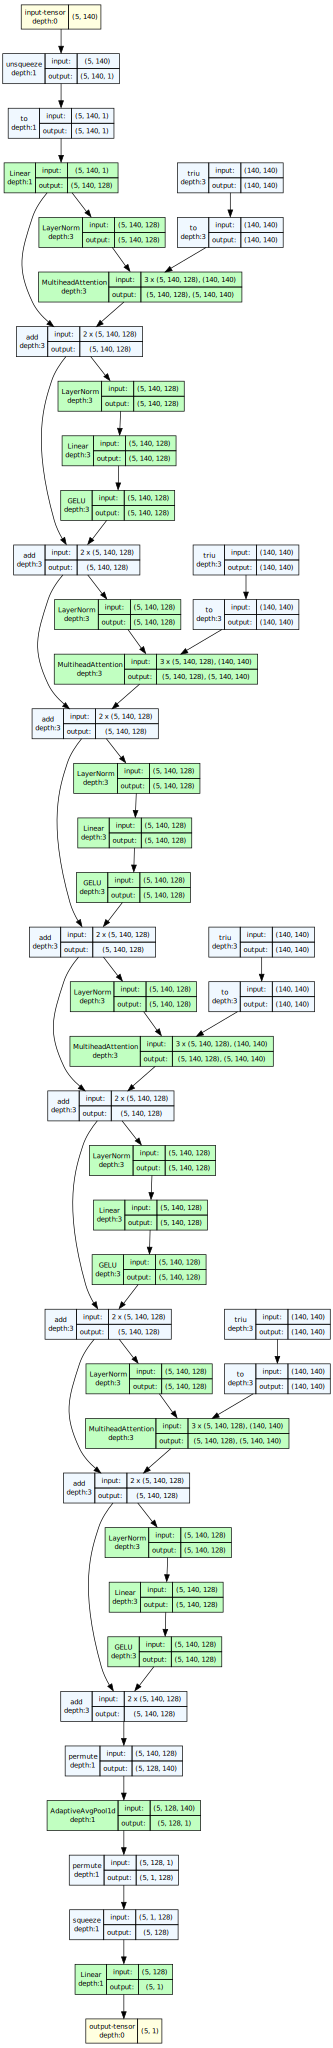

In [20]:
model_graph = draw_graph(model, input_size=x_train[0:5].shape, device=device,
                        hide_inner_tensors=True,hide_module_functions=True,
                        expand_nested=False, depth=3)
model_graph.visual_graph

In [47]:
batch_size = 32
xy_train = torch.utils.data.DataLoader(list(zip(torch.Tensor(x_train),\
                                                torch.Tensor(y_train))),\
                                       shuffle=True, batch_size=batch_size)
xy_val = torch.utils.data.DataLoader(list(zip(torch.Tensor(x_val),\
                                              torch.Tensor(y_val))),\
                                     shuffle=False, batch_size=batch_size)

In [48]:
logger = pl.loggers.CSVLogger("lightning_logs",
                              name="Term-Project",
                              version="demo-0")

In [49]:
# logger = pl.loggers.CSVLogger("logs",name="Term-Project",)
trainer = pl.Trainer(max_epochs=100,
                     logger=logger,
                     enable_progress_bar= True,
                     log_every_n_steps=0,
                     enable_checkpointing=True,
                     callbacks=[pl.callbacks.TQDMProgressBar(refresh_rate=1)])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [50]:
preliminary_result = trainer.validate(model, dataloaders=xy_val)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/opt/conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.11/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    0.11431670188903809    │
└───────────────────────────┴───────────────────────────┘

In [ ]:
trainer.fit(model, train_dataloaders=xy_train, val_dataloaders=xy_val)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type              | Params
---------------------------------------------------------
0 | loss               | BCEWithLogitsLoss | 0     
1 | embedding          | Linear            | 128   
2 | transformer_blocks | Sequential        | 332 K 
3 | AVGpool            | AdaptiveAvgPool1d | 0     
4 | logit              | Linear            | 129   
5 | sigmoid            | Sigmoid           | 0     
---------------------------------------------------------
332 K     Trainable params
0         Non-trainable params
332 K     Total params
1.330     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
final_result = trainer.validate(model, dataloaders=xy_val)

In [ ]:
logger.log_dir + "/metrics.csv"

In [ ]:
# results = pd.read_csv("logs/Term-Project/version_0/metrics.csv", delimiter=',')
results = pd.read_csv(logger.log_dir + "/metrics.csv", delimiter=',')
results

In [ ]:
# results = pd.read_csv("logs/Term-Project/version_0/metrics.csv", delimiter=',')
# results = pd.read_csv(logger.log_dir + "/metrics.csv", delimiter=',')

plt.plot(results["epoch"][np.logical_not(np.isnan(results["train_loss"]))],\
         results["train_loss"][np.logical_not(np.isnan(results["train_loss"]))],\
         label="Training")
plt.plot(results["epoch"][np.logical_not(np.isnan(results["val_loss"]))],\
         results["val_loss"][np.logical_not(np.isnan(results["val_loss"]))],\
         label="Validation")

plt.legend()
plt.ylabel("BCE Loss")
plt.xlabel("Epoch")
plt.savefig("./term-project-val-loss.png")
plt.show()

In [ ]:
# plt.plot(results["epoch"][np.logical_not(np.isnan(results["train_acc"]))], results["train_acc"][np.logical_not(np.isnan(results["train_acc"]))], label="Training")
# plt.plot(results["epoch"][np.logical_not(np.isnan(results["val_acc"]))], results["val_acc"][np.logical_not(np.isnan(results["val_acc"]))], label="Validation")
# plt.legend()
# plt.ylabel("Accuracy")
# plt.xlabel("Epoch")
# plt.savefig("./term-project-val-acc.png")
# plt.show()

In [ ]:
# print("Validation accuracy:",*["%.8f"%(x) for x in results['val_acc'][np.logical_not(np.isnan(results["val_acc"]))][0::10]])

In [ ]:
print("Validation loss:",*["%.8f"%(x) for x in results['val_loss'][np.logical_not(np.isnan(results["val_loss"]))][0::10]])